# Large Data

The bootstrapped library also provides functionality to deal with large-ish datasets. There are two situations where large data may pose issues. By large, we mean that it still fits reasnably in memory but is large enough that the bootstrap methods take considerable time to execute.
1. Memory
2. Time


In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time

In [2]:
import bootstrapped.bootstrap as bs
import bootstrapped.compare_functions as bs_compare
import bootstrapped.stats_functions as bs_stats

In [3]:
import scipy.sparse

In [4]:
# make n smaller if you are having trouble with memory size
n = 1000000

test_sparse = scipy.sparse.random(1, n, density=0.01, format='csr') * 1.1
ctrl_sparse = scipy.sparse.random(1, n, density=0.01, format='csr')

test = test_sparse.toarray().flatten()
ctrl = ctrl_sparse.toarray().flatten()

# Memory: Batch Size
Use 'iteration_batch_size' argument. This will help with the memory footprint at the cost of some speed.

In [5]:
# this will probably fail unless you have a LOT of memory
try:
    print(bs.bootstrap_ab(test, ctrl, bs_stats.sum, bs_compare.percent_change))
except MemoryError as e:
    print('There was a memory error - too much memory to be allocated')

There was a memory error - too much memory to be allocated


In [6]:
t = time.time()
results = bs.bootstrap_ab(test, ctrl, bs_stats.sum, bs_compare.percent_change, 
                          iteration_batch_size=100)

print('Results {}'.format(results))
print('')
print('Seconds Taken {}'.format(time.time() - t))

Results 10.3339160635    (6.70419586682, 13.7400311236)

Seconds Taken 476.877494097


# Time: Threads
Use the 'num_threads' argument. This will spawn @num_threads processes to divide an conquer. This will usually speed up execution at the cost of CPU utilizaiton.

In [7]:
t = time.time()
results = bs.bootstrap_ab(test, ctrl, bs_stats.sum, bs_compare.percent_change, 
                          iteration_batch_size=100, num_threads=3)

print('Results {}'.format(results))
print('')
print('Seconds Taken {}'.format(time.time() - t))

Results 10.3339160635    (6.78829998068, 13.920770811)

Seconds Taken 172.917182922


# Time & Memory: Sparse Data
We can also leverage the fact that the data is 99% zeros. 

In [8]:
t = time.time()
results = bs.bootstrap_ab(
    test_sparse, 
    ctrl_sparse, 
    bs_stats.sum, bs_compare.percent_change,
    iteration_batch_size=100)

print('Results {}'.format(results))
print('')
print('Seconds Taken {}'.format(time.time() - t))

Results 10.3339160635    (6.70165146807, 13.7529364647)

Seconds Taken 23.8291761875


Note that using sparse input arrays can be much slower if your data is mostly dense.

In [9]:
n = 5000

sparse = scipy.sparse.random(1, n, density=0.85, format='csr') 

dense = sparse.toarray().flatten()

In [10]:
# sparse array
t = time.time()
results = bs.bootstrap(sparse, bs_stats.sum)

print('Sparse Results {}'.format(results))
print('Sparse Seconds Taken {}'.format(time.time() - t))

print('')
print('')
# dense array
t = time.time()
results = bs.bootstrap(dense, bs_stats.sum)

print('Dense Results {}'.format(results))
print('Dense Seconds Taken {}'.format(time.time() - t))

Sparse Results 2118.43558532    (2073.46132986, 2163.23806261)
Sparse Seconds Taken 7.9109120369


Dense Results 2118.43558532    (2074.50529415, 2163.49309462)
Dense Seconds Taken 1.37844109535


# A tip on Power
Power calculation simulations can take a very long time. Fortunately this method is easily parallelizable. 

In [11]:
def run_simulation(num_loops, lift, data, seed):
    # you need to set the seed to make sure each thread produces different results
    np.random.seed(seed)
    results = []
    for _ in range(num_loops):
        
        # in real life you would use real data and then apply some hypothetical lift to it
        sel = np.random.random(len(data)) > 0.5
        
        test = data[sel] * lift
        ctrl = data[~sel]
        
        r = bs.bootstrap_ab(test, ctrl, bs_stats.sum, bs_compare.percent_change, 
                            iteration_batch_size=500)
        results.append(r)
        
    return results

In [12]:
data = np.random.normal(loc=100, scale=100, size=2000) 

In [15]:
import multiprocessing
num_threads = 8
iterations_per_thread = int(np.ceil(3000/num_threads))

pool = multiprocessing.Pool(num_threads)

pow_results = []
for seed in np.random.randint(0, 2**32 - 1, num_threads):
    r = pool.apply_async(run_simulation, (iterations_per_thread, 1.05, data, seed))
    pow_results.append(r)

pow_results = np.hstack([r.get() for r in pow_results])
pool.close()

In [16]:
import bootstrapped.power as bs_power

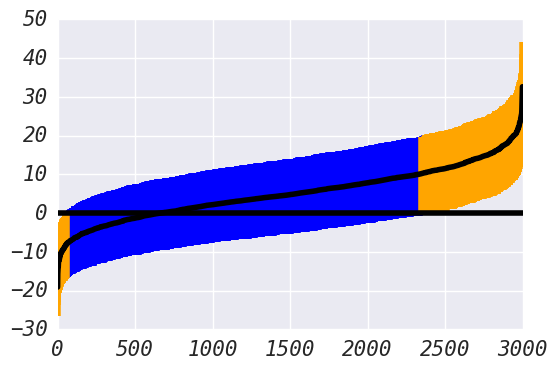

In [17]:
bs_power.plot_power(pow_results)

In [18]:
# This test was positive but we should only expect to see a significantly positive 
# result ~21% of the time
bs_power.power_stats(pow_results)

,Percent
Insignificant,77.000
Negative,22.200
Negative Significant,1.967
Positive,77.800
Positive Significant,21.033
